In [114]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import z,y,t
import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt


## First will Model a non-linear Pendulem

For generalisation will derive EoM with lagrange method

In [115]:
me.dynamicsymbols('q:3')

In [116]:
m,g,l_0,k = sym.symbols(['m','g','l_0','k'])
qs = 2
q = sym.Matrix(me.dynamicsymbols(f'q:{qs}'))
qd = sym.Matrix(me.dynamicsymbols(f'q:{qs}',1))
qdd = sym.Matrix(me.dynamicsymbols(f'q:{qs}',2))

### Potential Energy

In [156]:
half = sym.Rational(1,2)
U = -m*g*((l_0+q[1])*sym.cos(q[0])) + sym.Rational(1,2)*k*(q[1])**2
U

### Kinetic Energy

to be overly general will derive using a transformtion matrix to get from the base frame to the frame of the CoM, then will use the jacobian and a mass matrix to get the K.E of the Pendulom.

More Explictly

the kinetic enrgy of a partical is:

$K.E. = \frac{1}{2}\dot{\vec{x}}^TM(q)\dot{\vec{x}}$

Where, 

$\vec{v} = \left[ \begin{array}{} v_x & v_y & v_z & \omega_x & \omega_y & \omega_z  \end{array}  \right]^T $

$ M = \left[\begin{matrix}m & 0 & 0 & 0 & 0 & 0\\0 & m & 0 & 0 & 0 & 0\\0 & 0 & m & 0 & 0 & 0\\0 & 0 & 0 & I_{xx} & I_{xy} & I_{xz}\\0 & 0 & 0 & I_{xy} & I_{yy} & I_{yz}\\0 & 0 & 0 & I_{xz} & I_{yz} & I_{zz}\end{matrix}\right] $

To convert this into joint space (e.g. generalised coordinates) can use the Jacobian

$\dot{\vec{x}} = \mathbf{J}\dot{\vec{q}} $

$ K.E =\frac{1}{2}\dot{\vec{q}}^T \mathbf{J}^T M(q)  \mathbf{J}  \dot{\vec{q}} $

J is defined as $\mathbf{J} = \frac{\partial x}{\partial q}$

hence if we find the transform $\vec{x} = \mathbf{A}\vec{q}$, we can find J, by taking the partial derivates of the RHS with respect to each of the generilsed coordinates



In [158]:
me.mechanics_printing()
# get the transform matrix
Transform = symt.HomogenousTransform().R_x(-sym.pi*sym.Rational(1,2)+q[0]).Translate(0,q[1]+l_0,0)
# get the jacobian of x,y,z positon
J_xyz = Transform.Transform_point([0,0,0]).jacobian(q)
# get jacobian of rotations
J_r = sym.Matrix([q[0],0,0]).jacobian(q)

J=sym.zeros(6,len(q))
J[:3,:] = J_xyz
J[3:,:] = J_r
J

⎡         0              0    ⎤
⎢                             ⎥
⎢ (l₀ + q₁)⋅cos(q₀)   sin(q₀) ⎥
⎢                             ⎥
⎢-(-l₀ - q₁)⋅sin(q₀)  -cos(q₀)⎥
⎢                             ⎥
⎢         1              0    ⎥
⎢                             ⎥
⎢         0              0    ⎥
⎢                             ⎥
⎣         0              0    ⎦

In [159]:
# create mass matrix of CoM in its frame
M_q = sym.diag(m,m,m,0,0,0)

#calculate the mass Matrix
M = J.T*M_q*J
M.simplify()
M
#calculate the K.E
T = (sym.Rational(1,2)*qd.T*M*qd)[0]
T

In [160]:
Lag = sym.Matrix([sym.simplify(T-U)])
Lag.jacobian(qd).diff(me.dynamicsymbols._t).T
sym.simplify(-U)

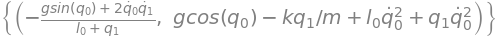

In [161]:
# calculate LHS of Lagranagian Equation
Lag = sym.Matrix([T-U])
term_1 = Lag.jacobian(qd).diff(me.dynamicsymbols._t).T
term_2 = Lag.jacobian(q).T
EoM = term_1-term_2

sym.simplify(EoM)

# solve for each acceleration term
a_eq = sym.linsolve(list(EoM[:]),list(qdd))
a_eq

In [162]:
# solve for each acceleration term
a_eq = sym.linsolve(list(EoM[:]),list(qdd))

# create funcs
funcs = []
for i in range(0,len(q)):
    funcs.append(sym.lambdify((m,g,l_0,k,q,qd),a_eq.args[0][i]))

# create single sys func
def deriv(t,y,m,g,l_0,k):
    result = ()
    qs=[]
    qds=[]
    for i in range(0,len(q)):
        qs.append(y[i*2])
        qds.append(y[i*2+1])
        
    for i in range(0,len(q)):
        result = (result + (y[i*2+1],))
        
        v = funcs[i](m,g,l_0,k,qs,qds)  
        
        result = (result + (v,))
    
    #ThetaDot = z1
    #z1dot = thetadd_func(m,g,l_0,[Theta],[z1])
    
    return result
deriv(0,[0,0,0,0],1,10,1,1)

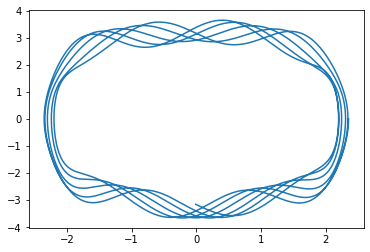

In [164]:
# Maximum time, time point spacings and the time grid (all in s).
tmax, dt = 20, 0.01
t = np.arange(0, tmax+dt, dt)
# Initial conditions: theta, dtheta/dt, L, dL/dt
y0 = [3*np.pi/4, 0,-0.1,0]
yData = solve_ivp(lambda t,y:deriv(t,y,2,10,1,100),(0,20),y0,method='LSODA',max_step=0.01,min_step= 0.000001)

yData.y[0][0]
fig = plt.figure()
ax = plt.plot(yData.y[0],yData.y[1])

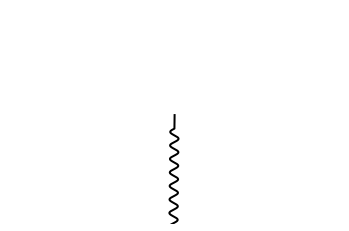

In [165]:
from matplotlib.animation import writers
writers.reset_available_writers()
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
mywriter = animation.FFMpegWriter()
#plt.rcParams['animation.ffmpeg_path'] =r'C:\Users\qe19391\OneDrive - University of Bristol\Desktop\ffmpeg\ffmpeg-20200211-f15007a-win64-static\bin\ffmpeg.exe'
plt.rcParams['animation.convert_path'] = r'C:\Users\qe19391\OneDrive - University of Bristol\Documents\Programs\ImageMagick-7.0.9-22\magick.exe'
rc('animation', html='html5')


def plot_spring(theta, L,spring):
    """Plot the spring from (0,0) to (x,y) as the projection of a helix."""
    # Spring turn radius, number of turns
    rs, ns = 0.05, 10
    # Number of data points for the helix
    Ns = 1000
    # We don't draw coils all the way to the end of the pendulum:
    # pad a bit from the anchor and from the bob by these number of points
    ipad1, ipad2 = 100, 150
    w = np.linspace(0, L, Ns)
    # Set up the helix along the x-axis ...
    xp = np.zeros(Ns)
    xp[ipad1:-ipad2] = rs * np.sin(2*np.pi * ns * w[ipad1:-ipad2] / L)
    # ... then rotate it to align with  the pendulum and plot.
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    xs, ys = - R @ np.vstack((xp, w))
    spring.set_data(xs, ys)

def plot_FWT(theta, d, L,fwt):
    xs = [0,L*np.sin(theta)]
    ys = [d,(d)-(L*np.cos(theta))]
    fwt.set_data(xs,ys)
    
def plot_sys(theta, d, L, ax, r=0.1):
    plot_spring(np.pi,1)
    plot_FWT(np.pi/2,0,1)
    c0 = Circle((0, d+1), r/2, fc='k', zorder=10)
    ax.add_patch(c0)
    ax.set()

    
fig = plt.figure()
ax = plt.axes(xlim=(-1.5,1.5),ylim=(-2.5,2.5))
ax.axis('equal')
ax.set()
fwt, = ax.plot([], [], 'r-',lw=2) 
spring, = ax.plot([], [], 'k-',lw=2) 

# initialization function 
def init(): 
    # creating an empty plot/frame 
    fwt.set_data([], [])
    spring.set_data([],[])              
    return fwt,spring
                    
def animate(i):
    theta = yData.y[0][i]
    d = yData.y[2][i]
    #d = 0
    #plot_FWT(theta,d+1,1,fwt)
    plot_spring(theta,d+1,spring)
    return fwt,spring
                    
plt.axis('off')    
#plt.rcParams['animation.ffmpeg_path'] = r'.'                    
# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(yData.t), interval=20, blit=True)
# equivalent to rcParams['animation.html'] = 'html5'
#anim
# anim.save(r'C:\Users\qe19391\OneDrive - University of Bristol\Desktop\mymovie.mp4',writer=mywriter)
#plt.show()
#mywriter = animation.FFMpegWriter()
#animation.writers['ffmpeg'] = mywriter
#writer = animation.ImageMagickFileWriter()
HTML(anim.to_html5_video())

In [70]:
yData.y[1].min()